In [ ]:
!pip install langchain transformers torchaudio librosa pdfplumber pytesseract opencv-python

In [ ]:
!pip install openai==0.28

In [ ]:
!pip install llama-index

In [ ]:
!pip install llama-index-multi-modal-llms-anthropic
!pip install llama-index-vector-stores-qdrant
!pip install matplotlib

In [22]:
from google.colab import auth
auth.authenticate_user()

In [31]:
!pip install python-pptx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.9 MB/s eta 0:00:00


In [2]:
import openai
from transformers import pipeline
import torch
import torchaudio
import librosa
import pdfplumber
import pytesseract
import cv2
from PIL import Image
import requests
from io import BytesIO

In [3]:
from google.colab import userdata
openai.api_key = userdata.get('OPENAI_API_KEY')
claude_api_key = userdata.get('CLAUDE_API_KEY')
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [18]:
import vertexai
from vertexai.generative_models import GenerativeModel, SafetySetting, FinishReason

# Initialize Vertex AI with your project and location
vertexai.init(project="geminiusecases", location="us-west1")

# Load the model
model = GenerativeModel("gemini-1.5-flash-001")

# Define generation config
generation_config = {
    "max_output_tokens": 8192,  # Max output tokens (adjust as necessary)
    "temperature": 1.0,          # Sampling temperature
    "top_p": 0.95,               # Top-p sampling
}

# Define safety settings (Optional, but recommended for content moderation)
safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

## Audio Processing (Using OpenAI's Whisper)

In [5]:
import openai
import torchaudio

# Load your audio file
audio_file_path = "example_audio.wav"

# Transcribe the audio using Whisper
audio_file = open(audio_file_path, "rb")
response = openai.Audio.transcribe("whisper-1", audio_file)

print("Transcribed Audio:")
print(response['text'])

Transcribed Audio:
And I'm the real thing, the almighty Prince Vegeta!


## Image Generation (Using OpenAI’s DALL-E for Image Generation)

In [6]:
import openai
from PIL import Image
import requests
from io import BytesIO

# Example image processing: Image generation using DALL-E
response = openai.Image.create(
    prompt="A futuristic cityscape with flying cars",
    n=1,
    size="1024x1024"
)

# Get the URL of the generated image
image_url = response['data'][0]['url']

# Download and open the image
response_image = Image.open(requests.get(image_url, stream=True).raw)

# Save the image locally
image_path = "/content/generated_image.png"
response_image.save(image_path)

# Print the path to the saved image
print(f"Image saved to {image_path}")

Image saved to /content/generated_image.png


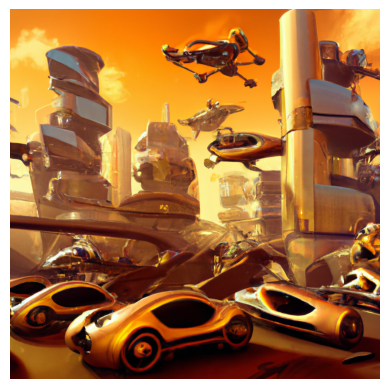

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
img = Image.open('/content/generated_image.png')

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

##  Use Anthropic to understand Images from Local directory

In [10]:
import os

os.environ["ANTHROPIC_API_KEY"] = userdata.get('CLAUDE_API_KEY')  # Your ANTHROPIC API key here

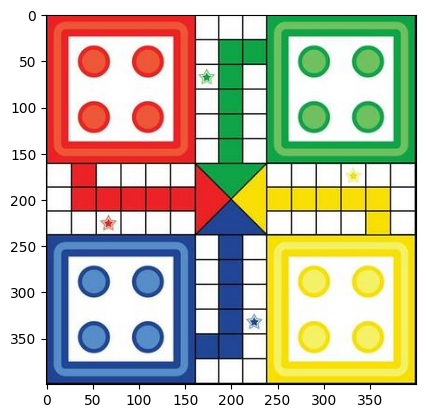

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/example_image.jpg")
plt.imshow(img)

In [12]:
from llama_index.core import SimpleDirectoryReader
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

# put your local directore here
image_documents = SimpleDirectoryReader(
    input_files=["/content/example_image.jpg"]
).load_data()

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

In [13]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response)

The image shows a colorful illustration resembling a Ludo board game layout. There are four large squares in red, green, blue and yellow, each containing four smaller circles of the same color. These large squares are connected by paths made up of smaller squares in alternating colors. In the center where the paths intersect, there are green and yellow triangles pointing in opposite directions. The overall composition is bright, geometric and symmetrical, evoking the look of a classic board game.


## Use `AnthropicMultiModal` to reason images from URLs

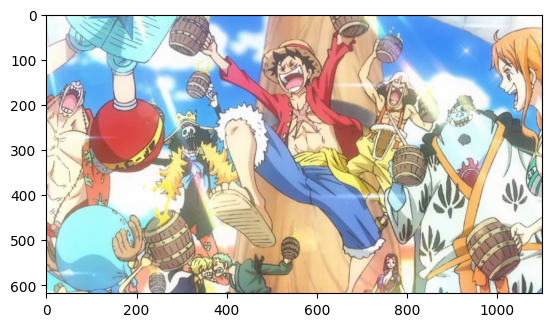

In [14]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/10/The-Straw-Hats-party-hard-in-One-Piece.jpg?q=50&fit=crop&w=1100&h=618&dpr=1.5",
    # Add yours here!
]

img_response = requests.get(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

image_url_documents = load_image_urls(image_urls)

In [15]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_url_documents,
)

print(response)

The image shows a group of animated characters from the One Piece manga/anime series. The characters are standing together, cheering and celebrating with their arms raised. They are wearing colorful and distinctive outfits that match their unique designs and personalities. The background shows a bright blue sky with white clouds, giving an upbeat and joyful atmosphere to the scene. The characters' exaggerated expressions and poses convey a sense of excitement, camaraderie and triumph.


## Open AI Image summarization using Vision Models

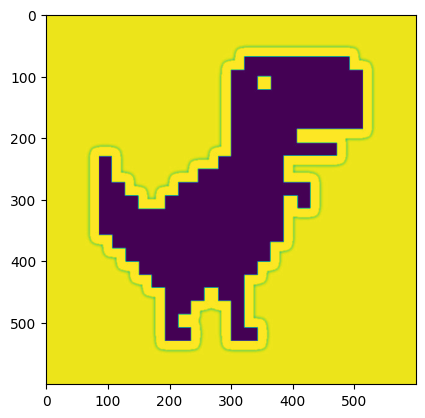

In [13]:
img = Image.open("/content/example_image_2.jpg")
plt.imshow(img)

In [10]:
import base64
import requests

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "/content/example_image_2.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {openai.api_key}"
}

payload = {
  "model": "gpt-4o-mini",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What’s in this image?"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

response_text = response.json()['choices'][0]['message']['content']
print(response_text)

The image features a black, pixelated dinosaur, resembling a T-rex, in a simple, cartoonish style. This type of design is commonly associated with retro video games or web graphics.


## Document Summarization

In [33]:
import fitz  # PyMuPDF

def summarize_document(pdf_file):
    # Open the PDF and extract text
    doc = fitz.open(pdf_file)
    text = ""
    for page in doc:
        text += page.get_text()

    # Prompt the model to summarize the extracted text
    prompt = f"Summarize the following document:\n{text[:2000]}"  # limit the size of the input to ensure prompt fits
    response = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings
    )
    print("Summary:\n", response.text)

# Upload the PDF
pdf_file = '/content/example_document.pdf'
summarize_document(pdf_file)

Summary:
 The Hundred-Page Machine Learning Book by Andriy Burkov is a concise guide to the field, emphasizing that "machine learning" is a misnomer. It argues that machines don't truly learn, but rather find mathematical formulas to predict outputs based on input data. This approach fails when inputs are slightly altered, unlike animal learning. The term "machine learning" was coined for marketing purposes, similar to "cognitive computing". Despite this, the book acknowledges the widespread use of the term and defines machine learning as the science of building machines capable of performing tasks without explicit programming.  It then dives into the core concepts of machine learning, including various techniques, applications, and challenges. 



## Image Caption Generation with Image Input Gemini


In [25]:
import base64
from PIL import Image
import io

def generate_image_caption(image_file):
    # Load the image
    with open(image_file, "rb") as img_f:
        image_bytes = img_f.read()

    # Convert the image bytes to a base64 string
    image_base64 = base64.b64encode(image_bytes).decode('utf-8')

    # Display the image (Optional)
    image = Image.open(io.BytesIO(image_bytes))
    image.show()  # Display the image in Colab or local environment

    # Provide a prompt for image captioning with the image content
    prompt = f"Generate a caption for the following image like which animal it resembles to. Image (Base64 encoded): {image_base64}"

    response = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings
    )

    # Print the generated caption
    print("Generated Caption:\n", response.text)

# Assuming the image file is uploaded and present at this path
image_file = '/content/temp_image.jpg'
generate_image_caption(image_file)

Generated Caption:
 This looks like a **sea turtle**. The shell is a giveaway, with its smooth, rounded shape and distinctive pattern. The image is a bit blurry, but we can still see the flippers. 



## Presentation Slide Summarization

In [32]:
from pptx import Presentation

def summarize_presentation(pptx_file):
    prs = Presentation(pptx_file)
    text = ""
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text += shape.text + "\n"

    # Prompt Gemini for a summary of the presentation content
    prompt = f"Summarize the following presentation:\n{text[:2000]}"  # limit the size of the input
    response = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings
    )
    print("Presentation Summary:\n", response.text)

pptx_file = '/content/example_presentation.pptx'
summarize_presentation(pptx_file)

Presentation Summary:
 This paper presents a novel method called Reinforcement Learning from AI Feedback (RLAIF) to improve code generation capabilities of small language models (LLMs) with fewer than 1 billion parameters. This is a significant challenge as these models often produce inaccurate code, struggle with API usage, and "hallucinate" incorrect details.

The RLAIF framework utilizes feedback from larger models like GPT-3.5 to train a reward model that assesses code quality. This reward model is then used with the PPO algorithm to further fine-tune a base model trained on the Gorilla dataset. The resulting model (MRL) significantly outperforms both the base model and a much larger model in terms of code executability, similarity to reference code, and code structure.

The paper demonstrates that smaller models can surpass the performance of larger models with the right training approach, highlighting the potential of RLAIF for improving code generation in resource-constrained se

In [37]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 37.2 MB/s eta 0:00:00


In [40]:
import os
import speech_recognition as sr
from moviepy.editor import VideoFileClip, AudioFileClip
from PIL import Image
import cv2

def extract_key_frames(video_file, interval=5):
    """
    Extract frames from the video at the given interval (in seconds) and return a list of file paths.
    """
    video = VideoFileClip(video_file)
    frame_list = []
    frame_dir = '/content/video_frames/'
    os.makedirs(frame_dir, exist_ok=True)

    for t in range(0, int(video.duration), interval):
        frame = video.get_frame(t)
        frame_file = os.path.join(frame_dir, f"frame_{t}.jpg")
        cv2.imwrite(frame_file, frame)
        frame_list.append(frame_file)

    return frame_list

def transcribe_audio_from_video(video_file):
    """
    Extract audio from the video and transcribe it using the SpeechRecognition library.
    """
    audio_file = "extracted_audio.wav"
    video = VideoFileClip(video_file)
    audio = video.audio
    audio.write_audiofile(audio_file)

    # Use SpeechRecognition to transcribe the audio
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source)
        transcription = recognizer.recognize_google(audio_data)

    return transcription

def analyze_video_content(video_file):
    # Load video and extract key information
    video = VideoFileClip(video_file)
    duration = video.duration
    print(f"Video Duration: {duration} seconds")

    # Step 1: Extract key frames
    frames = extract_key_frames(video_file, interval=5)
    print(f"Extracted {len(frames)} frames from the video.")

    # Step 2: Extract and transcribe audio
    transcription = transcribe_audio_from_video(video_file)
    print(f"Transcribed Audio: {transcription[:500]}...")  # Show first 500 characters

    # Step 3: Summarize content and send to Gemini model
    prompt = (f"Analyze the video with duration {duration} seconds, "
              f"with key frames extracted, and the following audio transcription:\n{transcription[:2000]}")

    response = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings
    )

    # Display the response from the model
    print("Video Analysis:\n", response.text)

# Example video file path
video_file = '/content/example_video.mp4'
analyze_video_content(video_file)

Video Duration: 34.05 seconds
Extracted 7 frames from the video.
MoviePy - Writing audio in extracted_audio.wav


MoviePy - Done.
Transcribed Audio: hello my name is semaj Sharma I'm a second year graduate student purchasing software engineering at San Jose State University and specializing in data science to lay a good foundation for a career in machine learning to become a Hands-On machine learning engineer I've been doing projects ranging from traditional machine learning and fine tuning additionally I am actively involved in the machine learning Club where I get to interact with peers to stay on top of the research advancements thank you...
Video Analysis:
 Please provide the key frames extracted from the video. I need those visuals to effectively analyze the video and its content. 

Once I have the key frames, I can analyze the video in the following ways:

* **Visual analysis:** I can analyze the key frames to see if they match the audio transcription, provide any additional context, or reveal any unspoken information. For example, are there any visual cues that suggest the speaker's passion

## Audio Summary

In [38]:
from pydub import AudioSegment
import speech_recognition as sr

def transcribe_audio(audio_file):
    # Load and convert the audio file to a format for recognition
    audio = AudioSegment.from_wav(audio_file)
    audio.export("temp.wav", format="wav")

    recognizer = sr.Recognizer()
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)

    # Prompt the model with the transcribed audio
    prompt = f"Transcribe and summarize the following audio content:\n{text}"
    response = model.generate_content(
        [prompt],
        generation_config=generation_config,
        safety_settings=safety_settings
    )
    print("Transcription Summary:\n", response.text)


audio_file = '/content/example_audio_2.wav'
transcribe_audio(audio_file)


Transcription Summary:
 ## Transcription and Summary:

**Transcription:**

"Wake up to reality. Nothing ever goes as planned in this accursed world. The longer you live, the more you will realize that the only things that truly exist in this reality are merely pain, suffering and futility. Listen, everywhere you look in this world, wherever there is light, that will always be shadows to be found as well. As long as there is a concept of pictures of relationship..."

**Summary:**

The audio clip presents a bleak and cynical view of reality. It argues that life is inherently filled with pain, suffering, and futility. The speaker suggests that despite any hopes or plans, the world will always bring disappointment. They emphasize the presence of darkness and shadows alongside every light, implying an inherent imbalance in existence. The final sentence, "As long as there is a concept of pictures of relationship," suggests a further exploration of the complexities of human connection within 